In [1]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
np.random.seed(0)

In [28]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix



In [4]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

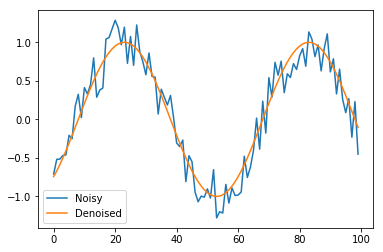

In [3]:
inp, out = sample(100)
plt.plot(inp, label='Noisy')
plt.plot(out, label ='Denoised')
plt.legend()


In [4]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

In [5]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [7]:
input_dim = 1
hidden_size = 32
num_layers = 1

In [8]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size)
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)
r

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CustomRNN(
  (rnn): GRU(1, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (act): Tanh()
)

In [9]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(201):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()


/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


(0, tensor(0.6413))
(20, tensor(0.1022))
(40, tensor(1.00000e-02 *
       8.7766))
(60, tensor(1.00000e-02 *
       8.4223))
(80, tensor(1.00000e-02 *
       7.3640))
(100, tensor(1.00000e-02 *
       5.9095))
(120, tensor(1.00000e-02 *
       4.1827))
(140, tensor(1.00000e-02 *
       3.9132))
(160, tensor(1.00000e-02 *
       3.8238))
(180, tensor(1.00000e-02 *
       3.5833))
(200, tensor(1.00000e-02 *
       3.3625))


In [10]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [11]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])


tensor(1.00000e-02 *
       3.3657)


/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


Text(0.5,1,'Sample num: 23')

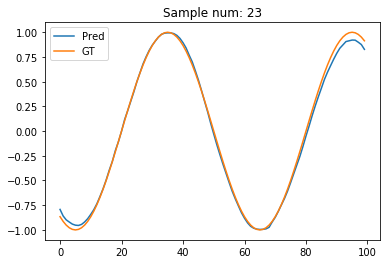

In [12]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

In [17]:
plt.rcParams['animation.ffmpeg_path'] = './ffmpeg'
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(np.array(predictions)[i, 0, :, 0].T, label='Pred')
    ax.plot(train_out[0, :], label='GT')
    ax.legend()
    ax.set_title(label)
 
anim = FuncAnimation(fig, update, frames=range(0, 201, 4), interval=20)
anim.save('learning.mp4',fps=20)
plt.close()

fig size: 72.0 DPI, size in inches [4. 3.]


In [5]:
X_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/X_train.txt")
X_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/X_test.txt")
Y_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/y_train.txt")
Y_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/y_test.txt")

X = np.vstack((X_train, X_test))
Y = np.hstack((Y_train, Y_test))

feature_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/features.txt",dtype='str')
label_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/activity_labels.txt", dtype='str')
label_names = [l[1] for l in label_names ]
label_names

X_train=X[:int(len(X)*0.7)]
X_test=X[int(len(X)*0.7):]
Y_train=Y[:int(len(Y)*0.7)]
Y_test=Y[int(len(Y)*0.7):]

X_train.shape

(7650, 561)

In [6]:
transition_label_names=['Activities', 'STAND_TO_SIT',
 'SIT_TO_STAND',
 'SIT_TO_LIE',
 'LIE_TO_SIT',
 'STAND_TO_LIE',
 'LIE_TO_STAND']

In [7]:
X_transition_train=X[:int(len(X)*0.6)]
X_transition_validation=X[int(len(X)*0.6):int(len(X)*0.8)]
X_transition_test=X[int(len(X)*0.8):]
Y_transition_train=np.where(Y[:int(len(Y)*0.6)] > 6, Y[:int(len(Y)*0.6)], 0)
Y_transition_validation=np.where(Y[int(len(Y)*0.6):int(len(X)*0.8)] > 6, Y[int(len(Y)*0.6):int(len(X)*0.8)], 0)
Y_transition_test=np.where(Y[int(len(Y)*0.8):] > 6, Y[int(len(Y)*0.8):], 0)

In [77]:
input_dim = 561
hidden_size = 512
num_layers = 4
output_dim=7

In [129]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    dtype = torch.FloatTensor

In [7]:
#dtype = torch.FloatTensor

In [87]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1).cuda()
        self.linear = nn.Linear(hidden_size*num_directions, output_size)
        self.act = nn.Softmax()
        #self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], self.output_size).cuda()
        #pred = nn.Sigmoid(self.linear(pred)).view(pred.data.shape[0], 12)
        return pred

r= CustomRNN(input_dim, hidden_size, output_dim).to(device)
r

CustomRNN(
  (rnn): GRU(561, 512, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=1024, out_features=7, bias=True)
  (act): Softmax()
)

In [15]:
def one_hot(y, labels):
    Y_onehot=[]
    for l in y:
        empty_label=np.zeros(len(labels))
        empty_label[labels.index(l)]=1.
        Y_onehot.append(empty_label)
    return(np.vstack(Y_onehot))


In [34]:
train_inp, train_out = X_train, one_hot(Y_train, range(1, len(label_names)+1))
test_inp, test_out = X_test, one_hot(Y_test, range(1, len(label_names)+1))

In [81]:
train_inp, train_out = X_transition_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
test_inp, test_out = X_transition_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])

In [88]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-4)
#loss_func = nn.L1Loss()
loss_func = F.binary_cross_entropy

for t in range(10000):
    hidden = None
    inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], output_dim))).type(dtype))
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.cpu().numpy())
    loss = loss_func(pred, out)
    ##loss = loss_func(pred.reshape(-1, 12).type(dtype), out.reshape(-1, 12).type(dtype))
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()


/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.2779, device='cuda:0'))
(20, tensor(1.2709, device='cuda:0'))
(40, tensor(1.2641, device='cuda:0'))
(60, tensor(1.2576, device='cuda:0'))
(80, tensor(1.2542, device='cuda:0'))
(100, tensor(1.2523, device='cuda:0'))
(120, tensor(1.2508, device='cuda:0'))
(140, tensor(1.2496, device='cuda:0'))
(160, tensor(1.2486, device='cuda:0'))
(180, tensor(1.2478, device='cuda:0'))
(200, tensor(1.2472, device='cuda:0'))
(220, tensor(1.2466, device='cuda:0'))
(240, tensor(1.2461, device='cuda:0'))
(260, tensor(1.2457, device='cuda:0'))
(280, tensor(1.2453, device='cuda:0'))
(300, tensor(1.2450, device='cuda:0'))
(320, tensor(1.2447, device='cuda:0'))
(340, tensor(1.2445, device='cuda:0'))
(360, tensor(1.2442, device='cuda:0'))
(380, tensor(1.2440, device='cuda:0'))
(400, tensor(1.2438, device='cuda:0'))
(420, tensor(1.2436, device='cuda:0'))
(440, tensor(1.2434, device='cuda:0'))
(460, tensor(1.2433, device='cuda:0'))
(480, tensor(1.2431, device='cuda:0'))
(500, tensor(1.2430, device='cu

(4140, tensor(1.2399, device='cuda:0'))
(4160, tensor(1.2399, device='cuda:0'))
(4180, tensor(1.2400, device='cuda:0'))
(4200, tensor(1.2399, device='cuda:0'))
(4220, tensor(1.2399, device='cuda:0'))
(4240, tensor(1.2399, device='cuda:0'))
(4260, tensor(1.2399, device='cuda:0'))
(4280, tensor(1.2399, device='cuda:0'))
(4300, tensor(1.2399, device='cuda:0'))
(4320, tensor(1.2399, device='cuda:0'))
(4340, tensor(1.2399, device='cuda:0'))
(4360, tensor(1.2399, device='cuda:0'))
(4380, tensor(1.2399, device='cuda:0'))
(4400, tensor(1.2399, device='cuda:0'))
(4420, tensor(1.2399, device='cuda:0'))
(4440, tensor(1.2399, device='cuda:0'))
(4460, tensor(1.2399, device='cuda:0'))
(4480, tensor(1.2399, device='cuda:0'))
(4500, tensor(1.2399, device='cuda:0'))
(4520, tensor(1.2399, device='cuda:0'))
(4540, tensor(1.2399, device='cuda:0'))
(4560, tensor(1.2399, device='cuda:0'))
(4580, tensor(1.2399, device='cuda:0'))
(4600, tensor(1.2399, device='cuda:0'))
(4620, tensor(1.2399, device='cuda:0'))


(8240, tensor(1.2399, device='cuda:0'))
(8260, tensor(1.2399, device='cuda:0'))
(8280, tensor(1.2399, device='cuda:0'))
(8300, tensor(1.2399, device='cuda:0'))
(8320, tensor(1.2399, device='cuda:0'))
(8340, tensor(1.2399, device='cuda:0'))
(8360, tensor(1.2399, device='cuda:0'))
(8380, tensor(1.2399, device='cuda:0'))
(8400, tensor(1.2399, device='cuda:0'))
(8420, tensor(1.2399, device='cuda:0'))
(8440, tensor(1.2399, device='cuda:0'))
(8460, tensor(1.2399, device='cuda:0'))
(8480, tensor(1.2399, device='cuda:0'))
(8500, tensor(1.2399, device='cuda:0'))
(8520, tensor(1.2399, device='cuda:0'))
(8540, tensor(1.2399, device='cuda:0'))
(8560, tensor(1.2399, device='cuda:0'))
(8580, tensor(1.2399, device='cuda:0'))
(8600, tensor(1.2399, device='cuda:0'))
(8620, tensor(1.2399, device='cuda:0'))
(8640, tensor(1.2399, device='cuda:0'))
(8660, tensor(1.2399, device='cuda:0'))
(8680, tensor(1.2399, device='cuda:0'))
(8700, tensor(1.2399, device='cuda:0'))
(8720, tensor(1.2399, device='cuda:0'))


In [89]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
pred_t = r(t_inp)

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [90]:
np.argmax(test_out, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [91]:
final_pred = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(label_names)+1))

In [97]:
final_pred = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(transition_label_names)+1))

In [92]:
accuracy_score(np.argmax(test_out, axis=1), np.argmax(pred_t.data.cpu().numpy(), axis=1))

0.9844464775846294

In [93]:
confusion_matrix(np.argmax(test_out, axis=1), np.argmax(pred_t.data.cpu().numpy(), axis=1))

array([[3107,    1,    0,    0,    0,    1,    0],
       [   3,   19,    0,    0,    0,    1,    0],
       [   0,    0,   10,    0,    0,    0,    0],
       [   0,    2,    0,   25,    0,    7,    1],
       [   0,    0,    0,    0,   19,    1,    5],
       [   5,    1,    0,   13,    0,   30,    0],
       [   0,    0,    0,    0,    7,    3,   18]])

In [8]:
def get_metrics(target, output):
        
        pred = np.round(output)
        
        tp = np.sum(((pred + target) == 2).astype(float), axis=0)
        fp = np.sum(((pred - target) == 1).astype(float), axis=0)
        fn = np.sum(((pred - target) == -1).astype(float), axis=0)
        tn = np.sum(((pred + target) == 0).astype(float), axis=0)

        acc = (tp + tn) / (tp + tn + fp + fn)
        try:
            prec = tp / (tp + fp)
        except ZeroDivisionError:
            prec = 0.0
        try:
            rec = tp / (tp + fn)
        except ZeroDivisionError:
            rec = 0.0
        try:
            specificity = tn / (tn + fp)
        except ZeroDivisionError:
            specificity = 0.0


        try:
            f1=2.*((prec*rec)/(prec+rec))
        except ZeroDivisionError:
            f1 = 0.0
        
        acc[acc != acc] = 0.
        prec[prec != prec] = 0.
        rec[rec != rec] = 0.
        specificity[specificity != specificity] = 0.
        f1[f1 != f1] = 0.
        
        balanced_accuracy = (rec + specificity) / 2.
        
        f1_micro, f1_macro, f1_weight, log_ls, roc = [], [], [], [], []
        for idx in range(target.shape[1]):
            y_test=target[:,idx]
            y_pred=pred[:,idx]
            
            f1_micro.append(f1_score(y_test, y_pred, average= 'micro'))
            f1_macro.append(f1_score(y_test, y_pred, average= 'macro'))
            f1_weight.append(f1_score(y_test, y_pred, average= 'weighted'))
            log_ls.append(log_loss(y_test, y_pred, labels=[0., 1.]))
            try:
                roc.append(roc_auc_score(y_test, output[:, idx]))
            except ValueError:
                roc.append(np.nan)

        return (balanced_accuracy, acc, prec, rec, specificity, f1, tp, fp, fn, tn, np.array(f1_micro), np.array(f1_macro), np.array(f1_weight), np.array(log_ls), np.array(roc))
    

In [101]:
results_metrics = get_metrics(test_out, final_pred)
metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
results = np.hstack((metric_names.reshape(-1, 1), np.vstack((transition_label_names, np.vstack(results_metrics)))))
with open("Transition_classification_results_BiGRU_Baseline__only_transitions_10000.csv", 'a') as f:
    pd.DataFrame(results).to_csv(f, header=False)


In [9]:
import ray
import ray.tune as tune

No handlers could be found for logger "ray.tune.logger"


In [48]:
ray.shutdown()

ConnectionError: Error 111 connecting to 192.168.1.45:20700. Connection refused.

In [49]:
ray.init(num_gpus=1)

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:37729 to respond...
Waiting for redis server at 127.0.0.1:31379 to respond...
Starting the Plasma object store with 13.00 GB memory.
Starting local scheduler with the following resources: {'GPU': 1, 'CPU': 12}.

View the web UI at http://localhost:8889/notebooks/ray_ui14228.ipynb?token=c0eb979623f7854bdcf906abcdba30a04e33700100f11bfc



{'local_scheduler_socket_names': ['/tmp/scheduler50002049'],
 'node_ip_address': '192.168.1.45',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store35743147', manager_name='/tmp/plasma_manager15454274', manager_port=31994)],
 'raylet_socket_names': [],
 'redis_address': '192.168.1.45:37729',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui14228.ipynb?token=c0eb979623f7854bdcf906abcdba30a04e33700100f11bfc'}

In [31]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1).cuda()
        self.linear = nn.Linear(hidden_size*num_directions, output_size)
        self.act = nn.Softmax()
        #self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], self.output_size).cuda()
        #pred = nn.Sigmoid(self.linear(pred)).view(pred.data.shape[0], 12)
        return pred

In [32]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 7
config["num_epochs"] = 10000
config["learning_rate"] = 1e-4

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    dtype = torch.FloatTensor

In [34]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1

In [35]:
train_inp, train_out = X_transition_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
val_inp, val_out = X_transition_validation, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
test_inp, test_out = X_transition_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])

In [41]:
def train_gru(config):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(val_inp.reshape((val_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    final_pred = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(transition_label_names)+1))
    results_metrics = get_metrics(test_out, final_pred)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((transition_label_names, np.vstack(results_metrics)))))
    with open("Transition_classification_results_BiGRU_Baseline_only_transitions_10000_w_validation.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)


In [ ]:
    reporter(ba = ba,
             acc = acc,
             prec = prec,
             rec = rec,
             spec = spec,
             f1 = f1,
             tp = tp,
             fp = fp,
             fn = fn,
             tn = tn,
             micro_f1 = micro_f1,
             macro_f1 = macro_f1,
             weighted_f1 = weighted_f1,
             log_ls = log_ls,
             auc_roc = auc_roc)

In [ ]:
train_gru(config)

In [50]:
all_trials = tune.run_experiments({
    "my_experiment": {
        'trial_resources': {'cpu': 11, 'gpu': 1},
        "run": train_gru,
        "stop": {"bal_acc": .99},
        "config": {"learning_rate": tune.grid_search([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]),
                   "num_epochs": tune.grid_search([100, 1000, 10000, 50000, 100000]),
                   "input_dim" : 561,
                   "hidden_size" : tune.grid_search([256, 512, 1024]),
                   "num_layers" : [1, 2, 3, 4, 6, 8],
                   "output_dim" : 7
                  }
    }
})


== Status ==
Using FIFO scheduling algorithm.


TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_0_hidden_size=256,learning_rate=0.1,num_epochs=100_2018-11-13_03-43-142sJKSS -> 
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 11/12 CPUs, 1/1 GPUs
Result logdir: /home/kavin/ray_results/my_experiment
PENDING trials:
 - train_gru_1_hidden_size=512,learning_rate=0.1,num_epochs=100:	PENDING
 - train_gru_2_hidden_size=1024,learning_rate=0.1,num_epochs=100:	PENDING
 - train_gru_3_hidden_size=256,learning_rate=0.01,num_epochs=100:	PENDING
 - train_gru_4_hidden_size=512,learning_rate=0.01,num_epochs=100:	PENDING
 - train_gru_5_hidden_size=1024,learning_rate=0.01,num_epochs=100:	PENDING
 - train_gru_6_hidden_size=256,learning_rate=0.001,num_epochs=100:	PENDING
 - train_gru_7_hidden_size=512,learning_rate=0.001,num_epochs=100:	PENDING
 - train_gru_8_hidden_size=1024,learning_rate=0.00

Result for train_gru_2_hidden_size=1024,learning_rate=0.1,num_epochs=100:
  bal_acc: 0.5013772595317676
  date: 2018-11-13_03-43-34
  done: true
  experiment_id: ffc2ad850675458a99ce6dd0bdce4159
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27239
  time_since_restore: 8.00833010673523
  time_this_iter_s: 1.0010480880737305
  time_total_s: 8.00833010673523
  timestamp: 1542098614
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_3_hidden_size=256,learning_rate=0.01,num_epochs=100_2018-11-13_03-43-34f6i8gY -> 
Suppressing duplicate error message.
Result for train_gru_3_hidden_size=256,learning_rate=0.01,num_epochs=100:
  bal_acc: 0.9177195172207895
  date: 2018-11-13_03-43-38
  done: false
  experiment_id: 747730e86aba4a2794854f273018df0b
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 192.168.1.4

Result for train_gru_5_hidden_size=1024,learning_rate=0.01,num_epochs=100:
  bal_acc: 0.9265128756860135
  date: 2018-11-13_03-43-54
  done: true
  experiment_id: baf943383dbb4eda81c385cfc9251747
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27328
  time_since_restore: 8.008094072341919
  time_this_iter_s: 1.0010459423065186
  time_total_s: 8.008094072341919
  timestamp: 1542098634
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_6_hidden_size=256,learning_rate=0.001,num_epochs=100_2018-11-13_03-43-54Mvk4uZ -> 
Suppressing duplicate error message.
Result for train_gru_6_hidden_size=256,learning_rate=0.001,num_epochs=100:
  bal_acc: 0.9250233340455479
  date: 2018-11-13_03-43-58
  done: false
  experiment_id: 0d687ef43b6a4a368229ab7dc0731b76
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 192.16

Result for train_gru_8_hidden_size=1024,learning_rate=0.001,num_epochs=100:
  bal_acc: 0.9050655244436501
  date: 2018-11-13_03-44-14
  done: true
  experiment_id: c0306cbcc880494ab2473bfdf13955ba
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27416
  time_since_restore: 8.008056879043579
  time_this_iter_s: 1.0010509490966797
  time_total_s: 8.008056879043579
  timestamp: 1542098654
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_9_hidden_size=256,learning_rate=0.0001,num_epochs=100_2018-11-13_03-44-14dkInMM -> 
Suppressing duplicate error message.
Result for train_gru_9_hidden_size=256,learning_rate=0.0001,num_epochs=100:
  bal_acc: 0.8430595896977024
  date: 2018-11-13_03-44-18
  done: false
  experiment_id: ca34fd3afb4045ebb2891be0a6f36a9b
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 192

Result for train_gru_11_hidden_size=1024,learning_rate=0.0001,num_epochs=100:
  bal_acc: 0.8705167949243418
  date: 2018-11-13_03-44-34
  done: true
  experiment_id: fa8e763a9a1848f194a0daf0b884b251
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27507
  time_since_restore: 8.008293867111206
  time_this_iter_s: 1.001037836074829
  time_total_s: 8.008293867111206
  timestamp: 1542098674
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_12_hidden_size=256,learning_rate=1e-05,num_epochs=100_2018-11-13_03-44-340PlohG -> 
Suppressing duplicate error message.
Result for train_gru_12_hidden_size=256,learning_rate=1e-05,num_epochs=100:
  bal_acc: 0.5477892020308557
  date: 2018-11-13_03-44-38
  done: false
  experiment_id: cf240db07db34620b3454fa5356b666a
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 19

Result for train_gru_14_hidden_size=1024,learning_rate=1e-05,num_epochs=100:
  bal_acc: 0.6580961548815426
  date: 2018-11-13_03-44-54
  done: true
  experiment_id: 620a9fb88a3f493baf84c6bef94d4d80
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27596
  time_since_restore: 8.008342742919922
  time_this_iter_s: 1.001046895980835
  time_total_s: 8.008342742919922
  timestamp: 1542098694
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_15_hidden_size=256,learning_rate=0.1,num_epochs=1000_2018-11-13_03-44-54eUnWzJ -> 
Suppressing duplicate error message.
Result for train_gru_15_hidden_size=256,learning_rate=0.1,num_epochs=1000:
  bal_acc: 0.8669921220114859
  date: 2018-11-13_03-45-07
  done: false
  experiment_id: aaedc5b7cbee4380a6a8253ee158c867
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 192.1

Result for train_gru_17_hidden_size=1024,learning_rate=0.1,num_epochs=1000:
  bal_acc: 0.6238800995584804
  date: 2018-11-13_03-46-21
  done: true
  experiment_id: 74bdf0a9b47c423fadd833618687a6f2
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27695
  time_since_restore: 49.04969000816345
  time_this_iter_s: 1.0010590553283691
  time_total_s: 49.04969000816345
  timestamp: 1542098781
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_18_hidden_size=256,learning_rate=0.01,num_epochs=1000_2018-11-13_03-46-22M0t3xe -> 
Suppressing duplicate error message.
Result for train_gru_18_hidden_size=256,learning_rate=0.01,num_epochs=1000:
  bal_acc: 0.9071029347036562
  date: 2018-11-13_03-46-34
  done: false
  experiment_id: 5d6ed459854645eb930bd5c8a2d88465
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 192

Result for train_gru_20_hidden_size=1024,learning_rate=0.01,num_epochs=1000:
  bal_acc: 0.9086912865267466
  date: 2018-11-13_03-47-48
  done: true
  experiment_id: e3681992057345a6bdca7959d8331c64
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 27856
  time_since_restore: 49.05026197433472
  time_this_iter_s: 1.0010368824005127
  time_total_s: 49.05026197433472
  timestamp: 1542098868
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_21_hidden_size=256,learning_rate=0.001,num_epochs=1000_2018-11-13_03-47-49J2drjk -> 
Suppressing duplicate error message.
Result for train_gru_21_hidden_size=256,learning_rate=0.001,num_epochs=1000:
  bal_acc: 0.8926935129528468
  date: 2018-11-13_03-48-02
  done: false
  experiment_id: 0d8fb53f89954263acf3bf7f818a3d3a
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 

Result for train_gru_23_hidden_size=1024,learning_rate=0.001,num_epochs=1000:
  bal_acc: 0.8988462237193922
  date: 2018-11-13_03-49-18
  done: true
  experiment_id: 5ea70754dfa04e0c9488393e3c7a963d
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 28023
  time_since_restore: 50.05073523521423
  time_this_iter_s: 1.001047134399414
  time_total_s: 50.05073523521423
  timestamp: 1542098958
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_24_hidden_size=256,learning_rate=0.0001,num_epochs=1000_2018-11-13_03-49-18KZnONV -> 
Suppressing duplicate error message.
Result for train_gru_24_hidden_size=256,learning_rate=0.0001,num_epochs=1000:
  bal_acc: 0.9076057787347824
  date: 2018-11-13_03-49-31
  done: false
  experiment_id: 5998f042ab3e4d95a51a583033f74e8f
  hostname: gHost
  iterations_since_restore: 1
  node_ip

Result for train_gru_26_hidden_size=1024,learning_rate=0.0001,num_epochs=1000:
  bal_acc: 0.8840897536743476
  date: 2018-11-13_03-50-46
  done: true
  experiment_id: 19b80dab66944f5daf2c60d358401247
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 28167
  time_since_restore: 50.050363063812256
  time_this_iter_s: 1.0010550022125244
  time_total_s: 50.050363063812256
  timestamp: 1542099046
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_27_hidden_size=256,learning_rate=1e-05,num_epochs=1000_2018-11-13_03-50-46AXHXsz -> 
Suppressing duplicate error message.
Result for train_gru_27_hidden_size=256,learning_rate=1e-05,num_epochs=1000:
  bal_acc: 0.811741269196335
  date: 2018-11-13_03-50-59
  done: false
  experiment_id: e359014172d145b4ad878a6a7c588002
  hostname: gHost
  iterations_since_restore: 1
  node_i

Result for train_gru_29_hidden_size=1024,learning_rate=1e-05,num_epochs=1000:
  bal_acc: 0.890135453278945
  date: 2018-11-13_03-52-14
  done: true
  experiment_id: 24a6ac4e069c46faa2b23f42ac5cfb31
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 28320
  time_since_restore: 50.05155682563782
  time_this_iter_s: 1.0010418891906738
  time_total_s: 50.05155682563782
  timestamp: 1542099134
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_30_hidden_size=256,learning_rate=0.1,num_epochs=10000_2018-11-13_03-52-14Gt0Obd -> 
Suppressing duplicate error message.
Result for train_gru_30_hidden_size=256,learning_rate=0.1,num_epochs=10000:
  bal_acc: 0.8785037027372297
  date: 2018-11-13_03-53-57
  done: false
  experiment_id: a6ac3839043442abb5a1145803bdc593
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 19

Result for train_gru_32_hidden_size=1024,learning_rate=0.1,num_epochs=10000:
  bal_acc: 0.6957867433826129
  date: 2018-11-13_04-04-45
  done: true
  experiment_id: e536fc5368314a2a8f2aac0c6de475e7
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 28548
  time_since_restore: 458.460294008255
  time_this_iter_s: 1.0005218982696533
  time_total_s: 458.460294008255
  timestamp: 1542099885
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_33_hidden_size=256,learning_rate=0.01,num_epochs=10000_2018-11-13_04-04-45xkTfcL -> 
Suppressing duplicate error message.
Result for train_gru_33_hidden_size=256,learning_rate=0.01,num_epochs=10000:
  bal_acc: 0.9026716286581487
  date: 2018-11-13_04-06-26
  done: false
  experiment_id: 1100c9fffe484014b55a952167d44ff8
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 19

Result for train_gru_35_hidden_size=1024,learning_rate=0.01,num_epochs=10000:
  bal_acc: 0.9166901064349167
  date: 2018-11-13_04-17-23
  done: true
  experiment_id: fc223fc00e0a409a8e3c1b1ba99ae88a
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 29261
  time_since_restore: 464.4648289680481
  time_this_iter_s: 1.0010499954223633
  time_total_s: 464.4648289680481
  timestamp: 1542100643
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_36_hidden_size=256,learning_rate=0.001,num_epochs=10000_2018-11-13_04-17-240T6bvP -> 
Suppressing duplicate error message.
Result for train_gru_36_hidden_size=256,learning_rate=0.001,num_epochs=10000:
  bal_acc: 0.8915069787259267
  date: 2018-11-13_04-19-09
  done: false
  experiment_id: ed20d0dcb36e456ba7ec7c3a0bd10ec9
  hostname: gHost
  iterations_since_restore: 1
  node_i

Result for train_gru_38_hidden_size=1024,learning_rate=0.001,num_epochs=10000:
  bal_acc: 0.8943828364140778
  date: 2018-11-13_04-30-14
  done: true
  experiment_id: 7618f434fee94f5b9f1a5c07683f6517
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 29976
  time_since_restore: 469.4700400829315
  time_this_iter_s: 1.0010411739349365
  time_total_s: 469.4700400829315
  timestamp: 1542101414
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_39_hidden_size=256,learning_rate=0.0001,num_epochs=10000_2018-11-13_04-30-14Ds2njO -> 
Suppressing duplicate error message.
Result for train_gru_39_hidden_size=256,learning_rate=0.0001,num_epochs=10000:
  bal_acc: 0.9062525653059158
  date: 2018-11-13_04-31-56
  done: false
  experiment_id: 3cad83e761744a68aff99fb312dd84f2
  hostname: gHost
  iterations_since_restore: 1
  nod

Result for train_gru_41_hidden_size=1024,learning_rate=0.0001,num_epochs=10000:
  bal_acc: 0.893828703893395
  date: 2018-11-13_04-43-02
  done: true
  experiment_id: 3cc82db1e0914cefaf2d75c5ef87c7f6
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 30694
  time_since_restore: 470.4685170650482
  time_this_iter_s: 1.0010440349578857
  time_total_s: 470.4685170650482
  timestamp: 1542102182
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_42_hidden_size=256,learning_rate=1e-05,num_epochs=10000_2018-11-13_04-43-02m71OpV -> 
Suppressing duplicate error message.
Result for train_gru_42_hidden_size=256,learning_rate=1e-05,num_epochs=10000:
  bal_acc: 0.9077180748796102
  date: 2018-11-13_04-44-45
  done: false
  experiment_id: 91404f1832a7408fabaf5bee338e98d2
  hostname: gHost
  iterations_since_restore: 1
  node_

Result for train_gru_44_hidden_size=1024,learning_rate=1e-05,num_epochs=10000:
  bal_acc: 0.8836320881087542
  date: 2018-11-13_04-55-53
  done: true
  experiment_id: 40d159eaa7bf48c4af3ed83717f3efc5
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 31419
  time_since_restore: 471.4753158092499
  time_this_iter_s: 1.001046895980835
  time_total_s: 471.4753158092499
  timestamp: 1542102953
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_45_hidden_size=256,learning_rate=0.1,num_epochs=50000_2018-11-13_04-55-53KOamJu -> 
Suppressing duplicate error message.
Result for train_gru_45_hidden_size=256,learning_rate=0.1,num_epochs=50000:
  bal_acc: 0.8539799225289444
  date: 2018-11-13_05-04-14
  done: false
  experiment_id: 0560e733b89b4a52b4c5c24cc1330ab6
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 1

Result for train_gru_47_hidden_size=1024,learning_rate=0.1,num_epochs=50000:
  bal_acc: 0.6217854653255764
  date: 2018-11-13_05-57-42
  done: true
  experiment_id: 2ca8141ae25b406f829a6d717185628f
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 1317
  time_since_restore: 2282.277619123459
  time_this_iter_s: 1.0010530948638916
  time_total_s: 2282.277619123459
  timestamp: 1542106662
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_48_hidden_size=256,learning_rate=0.01,num_epochs=50000_2018-11-13_05-57-42E6T4vH -> 
Suppressing duplicate error message.
Result for train_gru_48_hidden_size=256,learning_rate=0.01,num_epochs=50000:
  bal_acc: 0.878017532812688
  date: 2018-11-13_06-06-07
  done: false
  experiment_id: 7b18c55f82ba4c9b90ad058c478ef5c3
  hostname: gHost
  iterations_since_restore: 1
  node_ip: 19

Result for train_gru_50_hidden_size=1024,learning_rate=0.01,num_epochs=50000:
  bal_acc: 0.8917989810178517
  date: 2018-11-13_07-00-22
  done: true
  experiment_id: 745f05e3eb1c43a899f9fb887d341f43
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 5228
  time_since_restore: 2312.3181228637695
  time_this_iter_s: 1.0010440349578857
  time_total_s: 2312.3181228637695
  timestamp: 1542110422
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_51_hidden_size=256,learning_rate=0.001,num_epochs=50000_2018-11-13_07-00-22yfdASu -> 
Suppressing duplicate error message.
Result for train_gru_51_hidden_size=256,learning_rate=0.001,num_epochs=50000:
  bal_acc: 0.9078407194227236
  date: 2018-11-13_07-08-41
  done: false
  experiment_id: bd77214f1a1548a7aa82f8dccadfb825
  hostname: gHost
  iterations_since_restore: 1
  node_

Result for train_gru_53_hidden_size=1024,learning_rate=0.001,num_epochs=50000:
  bal_acc: 0.8846493853379885
  date: 2018-11-13_08-03-37
  done: true
  experiment_id: 5adca52d44244805b8312897f48bf65d
  hostname: gHost
  iterations_since_restore: 2
  node_ip: 192.168.1.45
  pid: 21579
  time_since_restore: 2338.337126970291
  time_this_iter_s: 1.001042127609253
  time_total_s: 2338.337126970291
  timestamp: 1542114217
  timesteps_since_restore: 0
  training_iteration: 2
  
TF not installed - cannot log with <class 'ray.tune.logger._TFLogger'>...
Created LogSyncer for /home/kavin/ray_results/my_experiment/train_gru_54_hidden_size=256,learning_rate=0.0001,num_epochs=50000_2018-11-13_08-03-37MoE1pW -> 
Suppressing duplicate error message.
Result for train_gru_54_hidden_size=256,learning_rate=0.0001,num_epochs=50000:
  bal_acc: 0.9049656686535107
  date: 2018-11-13_08-12-05
  done: false
  experiment_id: 9ff56469a6cf4beca3812125cd482499
  hostname: gHost
  iterations_since_restore: 1
  node

KeyboardInterrupt: 

In [190]:
from __future__ import division
from __future__ import print_function

import ray
from ray.tune import run_experiments, register_trainable
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest import HyperOptSearch
from hyperopt import hp

In [186]:
space = {"learning_rate": hp.uniform("learning_rate", 1, 1e-4),
                   "num_epochs": hp.uniform("num_epochs", 100, 100000),
                   "input_dim" : 561,
                   "hidden_size" : hp.uniform("hidden_size", 128, 1024),
                   "num_layers" : hp.uniform("num_layers", 1, 8),
                   "output_dim" : 7
                  }


In [191]:
register_trainable("bigru_tune", train_gru)
config = {
    "my_experiment": {
        "run": "bigru_tune",
        #"stop": {"mean_accuracy": 99},
        "stop": {
                "timesteps_total": 100
        },
    }
}


algo = HyperOptSearch(space, max_concurrent=4, reward_attr="ba")
scheduler = AsyncHyperBandScheduler(reward_attr="ba")
run_experiments(config, search_alg=algo, scheduler=scheduler)

AssertionError: HyperOpt must be installed!

In [27]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])


tensor(2.8911)


/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


ValueError: x and y can be no greater than 2-D, but have shapes (3279,) and (3279, 1, 1)

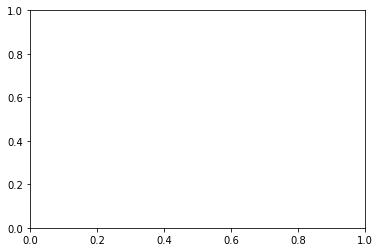

In [29]:
plt.plot(pred_t.data.numpy(), label='Pred')
plt.plot(test_out, label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = './ffmpeg'
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(np.array(predictions)[i, 0, :, 0].T, label='Pred')
    ax.plot(train_out[0, :], label='GT')
    ax.legend()
    ax.set_title(label)
 
anim = FuncAnimation(fig, update, frames=range(0, 201, 4), interval=20)
anim.save('har_transitions_learning.mp4',fps=20)
plt.close()